In [ ]:
# default_exp datasets

In [ ]:
# hide
# missing
!git clone https://github.com/marcomatteo/steel_segmentation.git

In [ ]:
# hide
# missing
!pip install -e steel_segmentation

# Datasets

> Loading data for training DL models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/dev_nbs/03_datasets.ipynb)

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# hide
from nbdev.showdoc import *

In [3]:
# export
from steel_segmentation.metadata import *
from steel_segmentation.masks import *

from fastcore.test import *
from fastai.vision.all import *
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split

from PIL import Image
import pandas as pd
import numpy as np
import os
import cv2

from torch.utils.data import Dataset, sampler
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
import albumentations as alb

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()

## Classification Fast.ai

I take this section to apply the layered approach of the fast.ai library to the classification `Dataset`. It will be a verbose documentation.

### DataBlock API

Fast.ai Datablock API to create `fastai.data.core.Datasets` class.

Data Block API from FastAI:

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock()),
    get_x=ColReader(0, pref=train_path),
    get_y=ColReader(1, label_delim=' '),
    splitter=RandomSplitter(valid_pct=0.2))

Now we can check that all is alright passing a `source` into the `dblock` and the API returns all the process explained.

In [5]:
# all training images
dsets = dblock.datasets(train_multi, verbose=True)

0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': Path('../data/train_images'), 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': ' '} -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}


In [13]:
len(dsets.train), len(dsets.valid), type(dsets.valid)

(10055, 2513, fastai.data.core.Datasets)

In [84]:
# only defected images
df = train_multi.loc[train_multi["ClassId_multi"]!='0']

dsets = dblock.datasets(df, verbose=True)

0        0002cc93b.jpg             1
4        0007a71bf.jpg             3
5        000a4bcdd.jpg             1
6        000f6bf48.jpg             4
7        0014fce06.jpg             3
...                ...           ...
12560    ffcf72ecf.jpg             3
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[6666 rows x 2 columns]
Found 6666 items
2 datasets of sizes 5333,1333
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': Path('../data/train_images'), 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': ' '} -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}


In [85]:
len(dsets.train), len(dsets.valid), type(dsets.valid)

(5333, 1333, fastai.data.core.Datasets)

The attribute `vocab` has all the types of labels.

In [86]:
dsets.vocab

['0', '1', '2', '3', '4']

In [87]:
t = dsets.train[0]
t

(PILImage mode=RGB size=1600x256, TensorMultiCategory([0., 1., 0., 0., 0.]))

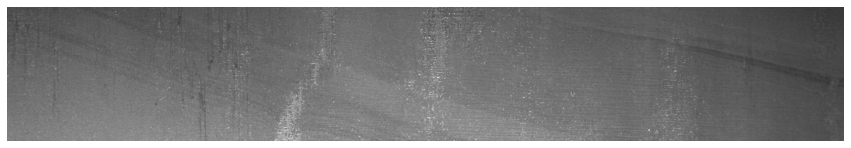

In [93]:
show_image(t[0], figsize=(15,5));

To visualize the decoded label we can use `dsets.decode`:

In [94]:
t_decoded = dsets.decode(t)
t_decoded

(PILImage mode=RGB size=1600x256, (#1) ['1'])

### Middle level API:

The pipeline to open an image:

In [95]:
get_x = ColReader(0, pref=train_path)
open_x = PILImage.create

In [96]:
item = df.iloc[0] 
get_x(item)

'../data/train_images/0002cc93b.jpg'

In [98]:
tls_x = TfmdLists(df, [get_x, open_x])

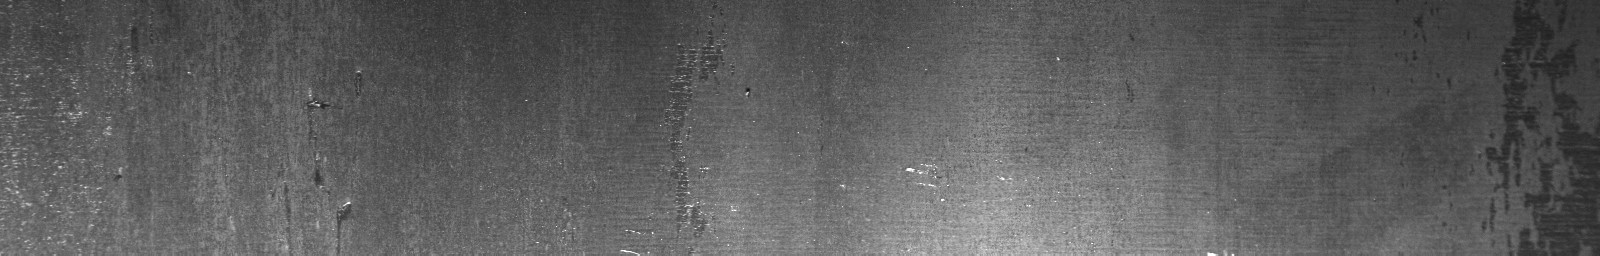

In [99]:
t = tls_x[0]
t

The pipeline to get the labels:

In [101]:
get_y = ColReader(1, label_delim=' ')
cat_y = MultiCategorize()
one_hot_y = OneHotEncode()

In [71]:
tls_y = TfmdLists(train_multi, [get_y, cat_y, one_hot_y])

In [68]:
t = tls_y[0]; t

TensorMultiCategory([0., 1., 0., 0., 0.])

In [69]:
tls_y.decode(t)

(#1) ['1']

The object closer to a `Dataset` in fast.ai, it uses a raw object and builds a tuple applying two or more pipelines.

In [102]:
x_tfms = [get_x, open_x]
y_tfms = [get_y, cat_y, one_hot_y]
dsets = Datasets(df, [x_tfms, y_tfms])

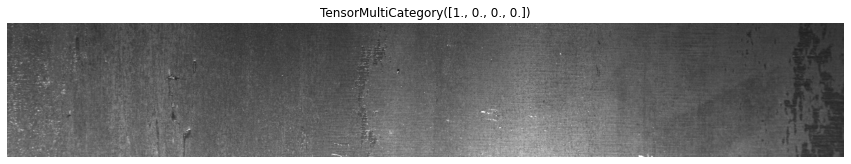

In [109]:
show_titled_image(dsets[0], figsize=(15,5))

Splitting into `train` and `valid` in the `Datasets`:

In [120]:
n = len(df)
split = train_test_split(range(n), test_size=0.2, random_state=69)
#split = L(df_split).map(lambda x: x.index.to_list())
split[0][:5]

[6383, 1721, 4414, 2638, 6661]

In [123]:
dsets = Datasets(df, [x_tfms, y_tfms], splits=split)

With `StratifiedKFold`:

In [126]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=69)
skf

StratifiedKFold(n_splits=3, random_state=69, shuffle=True)

In [137]:
X = df[["ImageId", "ClassId_multi"]].to_numpy()
y = df["ClassId_multi"].to_numpy()

In [146]:
for train_index, test_index in skf.split(X,y):
    print(
        f"{len(train_index)}: {train_index[:5]}", 
        f"{len(test_index)}: {test_index[:5]}", 
        sep='\n')
    split = [train_index, test_index]
    dsets = Datasets(df, [x_tfms, y_tfms], splits=split)
    print(f"Datasets train: {len(dsets.train)} and valid: {len(dsets.valid)} ", 
          end='\n\n')

4444: [0 2 3 4 5]
2222: [ 1  6  7  8 10]
Datasets train: 4444 and valid: 2222 

4444: [1 2 3 6 7]
2222: [ 0  4  5  9 15]
Datasets train: 4444 and valid: 2222 

4444: [0 1 4 5 6]
2222: [ 2  3 13 14 17]
Datasets train: 4444 and valid: 2222 



Now the `Datasets` are ready to be passed into a fastai `DataLoaders` to be converted to tensors, be normalized and get some transformation.

### Multi-class image segmentation

To get a `Datasets` object for training segmentation models in FastAi, we need to: 
- load the corrisponding labels (saved in `labels_dir` by the `preprocessing` module with the `create_mask` function)
- pair the images with labels with a `Dataset`

In [ ]:
# export
classes = [0, 1, 2, 3, 4]

In [ ]:
#hide
size = (256,1600)

In [ ]:
btfms = aug_transforms(
            size=size, 
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1) + [Normalize.from_stats(*imagenet_stats)]
btfms

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.1, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 Normalize -- {'mean': tensor([[[[0.4850]],
 
          [[0.4560]],
 
          [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],
 
          [[0.2240]],
 
          [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
 encodes: (TensorImage,object) -> encodes
 decodes: (TensorImage,object) -> decodes]

In [ ]:
def get_x(s):
    img_name = s["ImageId"]
    return train_path / str(img_name)

def get_y(s):
    img_name = s["ImageId"].split(".")[0] + "_P.png"
    return labels_path / img_name

dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=classes)),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=btfms)

In [ ]:
MaskBlock??

In [ ]:
AddMaskCodes??

In [ ]:
IntToFloatTensor??

In [ ]:
dsets = dblock.datasets(train_multi, verbose=True)

0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> PILBase.create


In [ ]:
t = dsets.train[-1]
t

(PILImage mode=RGB size=1600x256, PILMask mode=L size=1600x256)

In [ ]:
np.unique(t[1])

array([0, 3], dtype=uint8)

In [ ]:
t_decoded = dsets.decode(t)
t_decoded

(PILImage mode=RGB size=1600x256, PILMask mode=L size=1600x256)

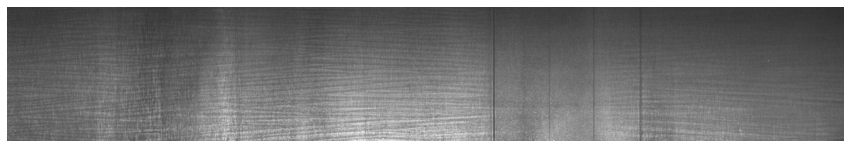

In [ ]:
img = t[0]
show_image(img, figsize=(15,5));

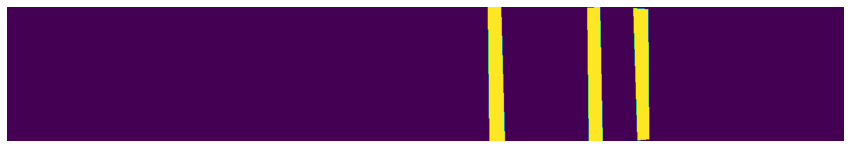

In [ ]:
mask = t[-1]
show_image(mask, figsize=(15,5));

## Pure Pytorch

The fast.ai Datablock API is very useful, we can load the images and apply transforms very quickly.
On the other side it can be a limit when experimenting with other models or with custom transformations and requires a deeper knoledge of the high-level API. 

Here some functions and classes from [this kernel](https://www.kaggle.com/rishabhiitbhu/unet-starter-kernel-pytorch-lb-0-88) for pure Pytorch `Dataset` and `DataLoader`.

In [ ]:
# export
def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5),  # only horizontal flip for now
            ]
        )
    list_transforms.extend(
        [
            alb.Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [ ]:
get_tsfms = get_transforms('train', *imagenet_stats)
get_tsfms

Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  Normalize(always_apply=False, p=1, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [ ]:
# export
class SteelDataset(Dataset):

    def __init__(self, df, mean, std, phase):
        self.df = df
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, df=self.df)
        image_path = train_path / image_id
        img = cv2.imread(str(image_path))
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']         # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1)  # 4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)

In [ ]:
steel_ds = SteelDataset(train_pivot, *imagenet_stats, 'train')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.8953) tensor(2.6400) torch.Size([4, 256, 1600])


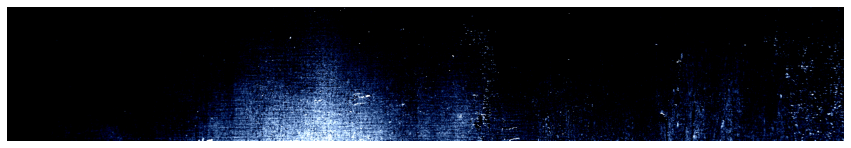

In [ ]:
# missing
x,y = steel_ds[0]

print(x.min(), x.max(), y.shape)
show_image(x, figsize=(15,5));

In [ ]:
get_tsfms.transforms

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_metadata.ipynb.
Converted 02_masks.ipynb.
Converted 03_datasets.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_metrics.ipynb.
Converted 06_loss.ipynb.
Converted 07_trainer.ipynb.
Converted 08_predict.ipynb.
Converted 09_visualize.ipynb.
Converted index.ipynb.
